In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
import numpy as np

## Deep RNNs for classification

In this Notebook we will show you how to build simple stacked RNNs using keras.
We will only stick to the architectures showed in the lecture and show you how to train on a simple task.

### Defining the Models

We will define custom stacked RNN networks by making use of the tensorflow base class for recurrent layers: 
https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN

You can use it to stack RNN cells as for example:
- a vanilla RNN Cell: https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNNCell
- a LSTM cell: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTMCell
- a GRU: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRUCell

You could also plug in your own self-designed rnn cells here as long as they are conform with the cell rquirements (they need a call() method, state_size and output_size attributes and a get_initial_state() mthode (refer to the docs)).

In [ ]:
class VanillaRNN(tf.keras.Model):
    
    def __init__(self, num_cells, hidden_size, output_size, return_sequences=False):
        """
        num_cells: how many simple RNN cells in the RNN
        hidden_size: shape that RNN cells output that is then given to the Dense layer
        output_size: output shape that is needed for the task
        return_sequences: boolean whether to return only the last output or the output of every element in the sequence
        """
        super(VanillaRNN, self).__init__()

        self.rnn = tf.keras.layers.RNN([tf.keras.layers.SimpleRNNCell(hidden_size) for _ in range(num_cells)], return_sequences)
        self.output_layer = tf.keras.layers.Dense(units=output_size, activation='sigmoid')
        
    
    def call(self, x):
        x = self.rnn(x)
        x = self.output_layer(x)
        return x

In [ ]:
# input: (batch_size, seq_length, input_size)
x = tf.ones((1,5,1))

rnn = VanillaRNN(1,1,10, True)
rnn(x)

<tf.Tensor: shape=(1, 5, 10), dtype=float32, numpy=
array([[[0.5832125 , 0.45901307, 0.56032944, 0.37911525, 0.5919632 ,
         0.4093241 , 0.6238191 , 0.5901366 , 0.63052034, 0.55934125],
        [0.6025157 , 0.44931614, 0.5744986 , 0.35188973, 0.6131725 ,
         0.38839296, 0.6516274 , 0.610951  , 0.6596383 , 0.57328445],
        [0.60432214, 0.44840285, 0.57583   , 0.3493661 , 0.61515355,
         0.3864373 , 0.6542027 , 0.61289597, 0.6623291 , 0.5745948 ],
        [0.60446244, 0.44833186, 0.57593334, 0.34917033, 0.61530733,
         0.38628545, 0.6544025 , 0.613047  , 0.6625378 , 0.57469654],
        [0.6044731 , 0.44832647, 0.57594126, 0.34915537, 0.61531913,
         0.38627386, 0.65441775, 0.6130585 , 0.6625537 , 0.57470435]]],
      dtype=float32)>

As you can see, when using layers from the keras API, the code for Vanilla RNN, LSTM and GRU is very similar. The only part differering is which Keras Cell type we are calling.

*Note that for the homework you are not allowed to use the inbuilt layers and have to implement them yourselves.*

In [ ]:
class LSTM(tf.keras.Model):
    
    def __init__(self, num_cells, hidden_size, output_size,  return_sequences=False):
        
        super(LSTM, self).__init__()
        self.rnn = tf.keras.layers.RNN([tf.keras.layers.LSTMCell(hidden_size) for _ in range(num_cells)], return_sequences)
        self.output_layer = tf.keras.layers.Dense(units=output_size, activation='sigmoid')
        
    
    def call(self, x):
        
        x = self.rnn(x)
        x = self.output_layer(x)
        return x

In [ ]:
x = tf.ones((1,5,1))
lstm = LSTM(1,10,1, True)
lstm(x)

<tf.Tensor: shape=(1, 5, 1), dtype=float32, numpy=
array([[[0.5007846 ],
        [0.5038153 ],
        [0.50720185],
        [0.5102341 ],
        [0.51274043]]], dtype=float32)>

In [ ]:
class GRU(tf.keras.Model):
    
    def __init__(self, num_cells, hidden_size,  output_size, return_sequences=False):
        
        super(GRU, self).__init__()
        self.rnn = tf.keras.layers.RNN([tf.keras.layers.GRUCell(hidden_size) for _ in range(num_cells)], return_sequences)
        self.output_layer = tf.keras.layers.Dense(units=output_size, activation='sigmoid')
        
    
    def call(self, x):
        
        x = self.rnn(x)
        x = self.output_layer(x)
        return x

In [ ]:
x = tf.ones((1,4,2))
gru = GRU(1,10,1, True)
gru(x)

<tf.Tensor: shape=(1, 4, 1), dtype=float32, numpy=
array([[[0.55064553],
        [0.5769111 ],
        [0.5904076 ],
        [0.59691   ]]], dtype=float32)>

### Defining the task

Integration Task: Determine if the (discounted) integral of a function is greater than 0 or not. This may chnage over time.


Don't worry about the code of the task, it is just some toy task we had lying around. But as it provides simple time series data it is perfect for apllying our RNN networks.

In [ ]:
class Integration_Task():
    """
    @params:
     - length: sequence_length/time_steps
     - size: input_size (default=1)
     - discount: discount factor for exponentially discounted sum
     - proto_length: default length of a single sample, if no other length is specified in the sampling statement ??
     - loc: mean of the noise used as input
     - scale: scale/SD of the noise used as input
    """

    def __init__(self, discount=1., length=100, size=1, batch_size=1, loc=0, scale=1.):
        self.length = length
        self.size = size
        self.batch_size = batch_size
        self.discount = discount
        self.loc = loc
        self.scale = scale
        self.train_loader = None  # set by generate_data_loader
        self.test_loader = None  # set by generate_data_loader
        self.default_obs_shape = (batch_size, length, size)
        
     
    def discount_cumsum(self, x, discount):
        """
        magic from rllab for computing discounted cumulative sums of vectors.
        input:
            vector x,
            [x0,
             x1,
             x2]
        output:
            [x0 + discount * x1 + discount^2 * x2,
             x1 + discount * x2,
             x2]
        """
        return signal.lfilter([1], [1, float(-discount)], x[::-1], axis=1)[::-1]
    
    def plot_input_target(self, n, length=None, style='seaborn'):
        mpl.style.use(style)
        length = (length or self.length)

        fig, axes = plt.subplots(2, sharex=True)
        
        input, target = self.generate_sample(length=length, batch_size=n)

        for i in range(n):
            axes[0].plot(input[i], alpha=0.7)
            axes[1].plot(target[i], alpha=0.7)
            axes[1].set_xlabel("Time [t]")
            axes[0].set_ylabel("White Noise")
            axes[1].set_ylabel("Binary Decision")
        fig.suptitle(f"Integration Task: {n} input and target sequences for {length} time steps")
        plt.tight_layout()
        plt.show()

    def generate_sample(self, length=None, size=None, batch_size=None, discount=None, loc=None, scale=None):
        """
        Function that samples an input target timesieres pair
        @output:
            sample: (batch_size, length, size)
            target: (batch_size, length, out_size)
        """
        length = (length or self.length)
        size = (size or self.size)
        batch_size = (batch_size or self.batch_size)
        shape = (batch_size, length, size)
        discount = (discount or self.discount)
        loc = (loc or self.loc)
        scale = (scale or self.scale)

        sample = np.random.normal(loc=loc, scale=scale, size=shape)

        target = (self.discount_cumsum(sample, discount) > 0).astype(np.int)
        return sample, target
    
        

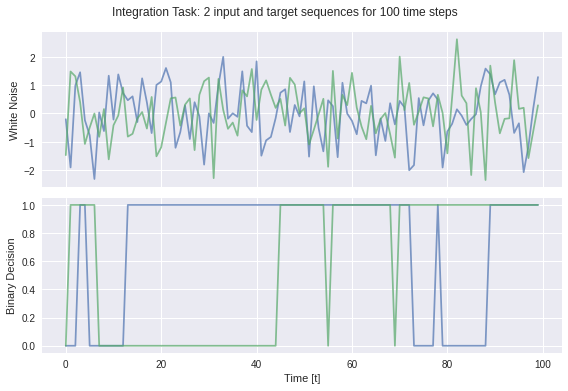

In [ ]:
task = Integration_Task()
task.plot_input_target(2)

### Training

The training loop will be a bit different from what you are used to as we do not have a fixed dataset nor any training data, as we are always able to generate new unseen data with our task class. Therefore we can compute te accuracy on each sample, as it is always new, and are not in need of any testing steps on seperate datasets.

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
    
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # accuracy using a 0.5 threshold
    acc = np.sum(np.abs((target-prediction))<0.5)/(target.shape[0]*target.shape[1])

    return np.mean(loss), acc


In [ ]:
def train(model, task, steps=5000, print_every=500, running_average_factor = 0.95):
    
    optimizer = tf.keras.optimizers.Adam()
    cross_entropy_loss = tf.keras.losses.MSE

    losses = []
    acces = []

    running_average_loss = 0
    running_average_acc = 0
    i=0

    for i in range(steps):
        # generating a new sample in each training step
        samples, targets = task.generate_sample()
        loss, acc = train_step(model, samples, targets, cross_entropy_loss, optimizer)
        
        # compute the running averages of training loss and accuracy
        running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * loss
        running_average_acc = running_average_factor * running_average_acc  + (1 - running_average_factor) * acc
        losses.append(running_average_loss)
        acces.append(running_average_acc)
        
        if i%print_every==0:
            print(f"Training step {i}: average loss is {np.round(losses[-1],2)}, accuracy of {np.round(acces[-1], 2)} %")
        
        if i == steps:
            break
        i+=1
    return losses, acces

In [ ]:
def visualize(losses, acces, name=''):
    plt.figure()
    plt.title(name)
    line1, = plt.plot(losses)
    plt.xlabel("Training steps")
    plt.ylabel("Loss")
    plt.show()
    plt.figure()
    line1, = plt.plot(acces)
    plt.xlabel("Training steps")
    plt.ylabel("Accuracy")
    plt.show()


Training step 0: average loss is 0.01, accuracy of 0.02 %
Training step 500: average loss is 0.12, accuracy of 0.83 %
Training step 1000: average loss is 0.11, accuracy of 0.85 %
Training step 1500: average loss is 0.07, accuracy of 0.91 %
Training step 2000: average loss is 0.11, accuracy of 0.85 %
Training step 2500: average loss is 0.08, accuracy of 0.89 %
Training step 3000: average loss is 0.08, accuracy of 0.9 %
Training step 3500: average loss is 0.08, accuracy of 0.9 %
Training step 4000: average loss is 0.08, accuracy of 0.9 %
Training step 4500: average loss is 0.06, accuracy of 0.93 %


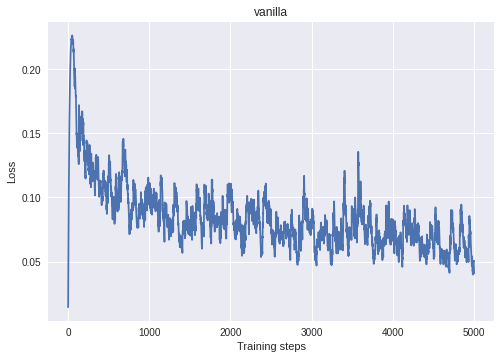

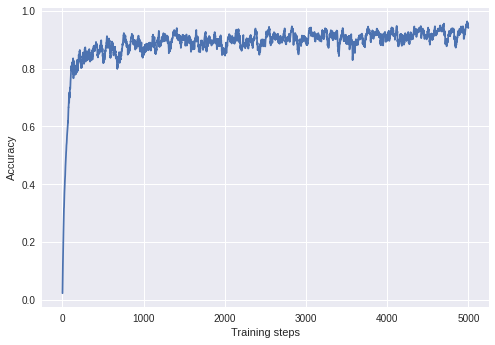

In [ ]:

model = VanillaRNN(num_cells=1,hidden_size=10,output_size=1,return_sequences=True)
task = Integration_Task(length=50)
losses, acces = train(model, task)
visualize(losses, acces, 'vanilla')

Training step 0: average loss is 0.01, accuracy of 0.03 %
Training step 500: average loss is 0.06, accuracy of 0.95 %
Training step 1000: average loss is 0.06, accuracy of 0.94 %
Training step 1500: average loss is 0.04, accuracy of 0.96 %
Training step 2000: average loss is 0.04, accuracy of 0.96 %
Training step 2500: average loss is 0.03, accuracy of 0.97 %
Training step 3000: average loss is 0.03, accuracy of 0.96 %
Training step 3500: average loss is 0.03, accuracy of 0.97 %
Training step 4000: average loss is 0.02, accuracy of 0.98 %
Training step 4500: average loss is 0.02, accuracy of 0.97 %


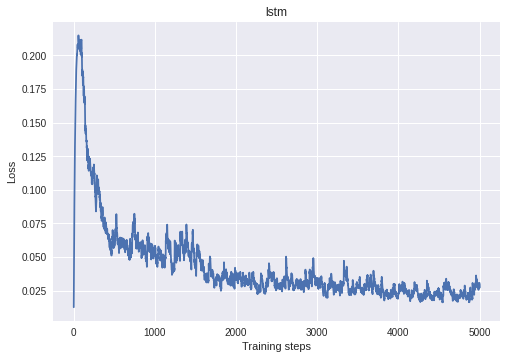

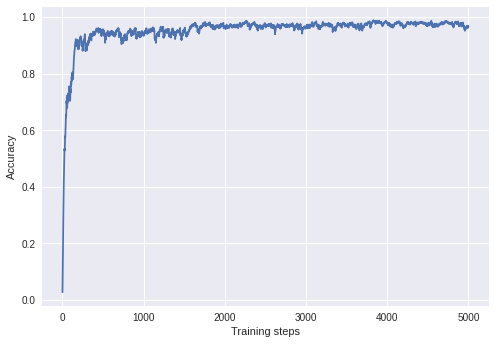

In [ ]:
model = LSTM(num_cells=1,hidden_size=10,output_size=1,return_sequences=True)
task = Integration_Task(length=50)
losses, acces = train(model, task)
visualize(losses, acces, 'lstm')

Training step 0: average loss is 0.01, accuracy of 0.04 %
Training step 500: average loss is 0.1, accuracy of 0.88 %
Training step 1000: average loss is 0.1, accuracy of 0.87 %
Training step 1500: average loss is 0.06, accuracy of 0.93 %
Training step 2000: average loss is 0.06, accuracy of 0.94 %
Training step 2500: average loss is 0.05, accuracy of 0.95 %
Training step 3000: average loss is 0.04, accuracy of 0.96 %
Training step 3500: average loss is 0.03, accuracy of 0.97 %
Training step 4000: average loss is 0.03, accuracy of 0.98 %
Training step 4500: average loss is 0.02, accuracy of 0.98 %


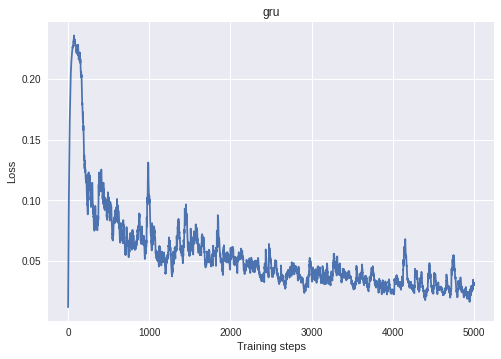

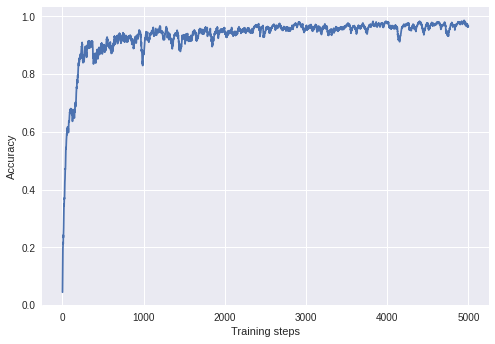

In [ ]:
model = GRU(num_cells=1,hidden_size=10,output_size=1,return_sequences=True)
task = Integration_Task(length=100)
losses, acces = train(model, task)
visualize(losses, acces, 'gru')